# Performing a simple inference task using the TerraTorch's script interface. 

## **Direct inference (or full image inference).**

In [27]:
import argparse
import os
from typing import List, Union
import re
import datetime
import numpy as np
import rasterio
import torch
import rioxarray
import yaml
from einops import rearrange
from terratorch.cli_tools import LightningInferenceModel
from terratorch.utils import view_api

### The directory in which we will save the model output.

In [28]:
output_dir = "inference_output"

### The path to the configuration (YAML) file.

In [29]:
config_file = "burn_scars_config.yaml"

### The path to the local checkpoint (a file storing the model weights).

In [30]:
checkpoint = "../checkpoints/Prithvi_EO_V2_300M_BurnScars.pt"

### The path for the directory containing the input images.

In [43]:
input_dir = "examples/"

### An image chosen to be used in the single-file inference. 

In [32]:
example_file = "examples/subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4_merged.tif"

### A list indicating the bands contained in the input files. 

In [33]:
predict_dataset_bands=[
      "BLUE",
      "GREEN",
      "RED",
      "NIR_NARROW",
      "-1", #"SWIR_1",
      "SWIR_2",
  ]

### A subset of the dataset bands to be used as input for the model. 

In [34]:
predict_output_bands = predict_dataset_bands

### Creating a directory to store the output (when it does not exist).

In [35]:
os.makedirs(output_dir, exist_ok=True)

In [36]:
with open(config_file, "r") as f:
    config_dict = yaml.safe_load(f)

### Instantiating the model from the config file and the others arguments defined previously.

In [37]:
lightning_model = LightningInferenceModel.from_config(config_file, checkpoint, predict_dataset_bands, predict_output_bands)

/home/jalmeida/.pyenv/versions/3.12.7/envs/sbsr/lib/python3.12/site-packages/lightning/pytorch/cli.py:528: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['-f', '/home/jalmeida/.local/share/jupyter/runtime/kernel-14250d3d-3b57-4b7a-862f-71ebc3c97834.json'], args=['--config', 'burn_scars_config.yaml', '--data.init_args.predict_dataset_bands', '[BLUE,GREEN,RED,NIR_NARROW,-1,SWIR_2]', '--data.init_args.predict_output_bands', '[BLUE,GREEN,RED,NIR_NARROW,-1,SWIR_2]'].
Seed set to 2
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in positio

### Performing the inference for a single file. The output is a tensor (`torch.Tensor`). 

In [38]:
prediction = lightning_model.inference(example_file)
prediction

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])

### Visualizing the input image. From the file object `fp` we select just the bands corresponding to RGB (indexes que correspondem aos índices 2, 1 and 0 of the TIFF file) for sake of visualization. Notice that we added a shift to white (`fp[[2,1,0]]+0.20`) in order to lighten the image. 

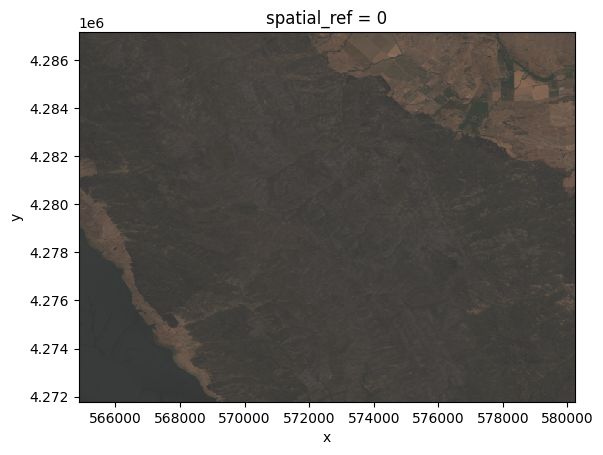

In [39]:
import rioxarray
fp = rioxarray.open_rasterio(example_file)
(fp[[2,1,0]]+0.20).plot.imshow(rgb="band")

### Visualizing the output image. 

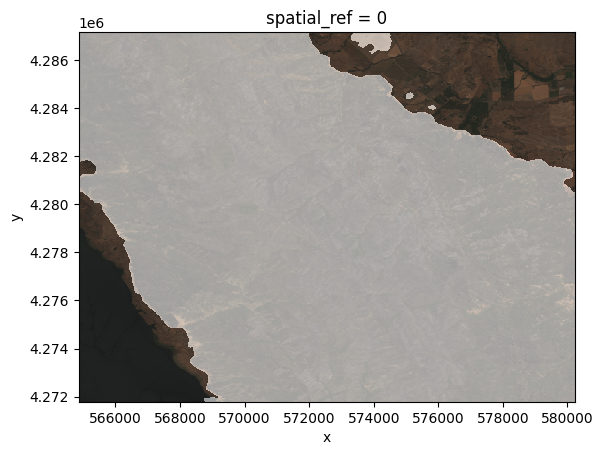

In [40]:
import matplotlib.pyplot as plt
(fp[[2,1,0]] + 0.10 + 0.5*np.stack(3*[prediction], axis=0)).plot.imshow(rgb="band")

### We also can perform inference for an entire directory of images by using the 

In [44]:
predictions, file_names = lightning_model.inference_on_dir(input_dir)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### This operation will return two lists, one containing predictions and another with the names of the corresponding input files. 

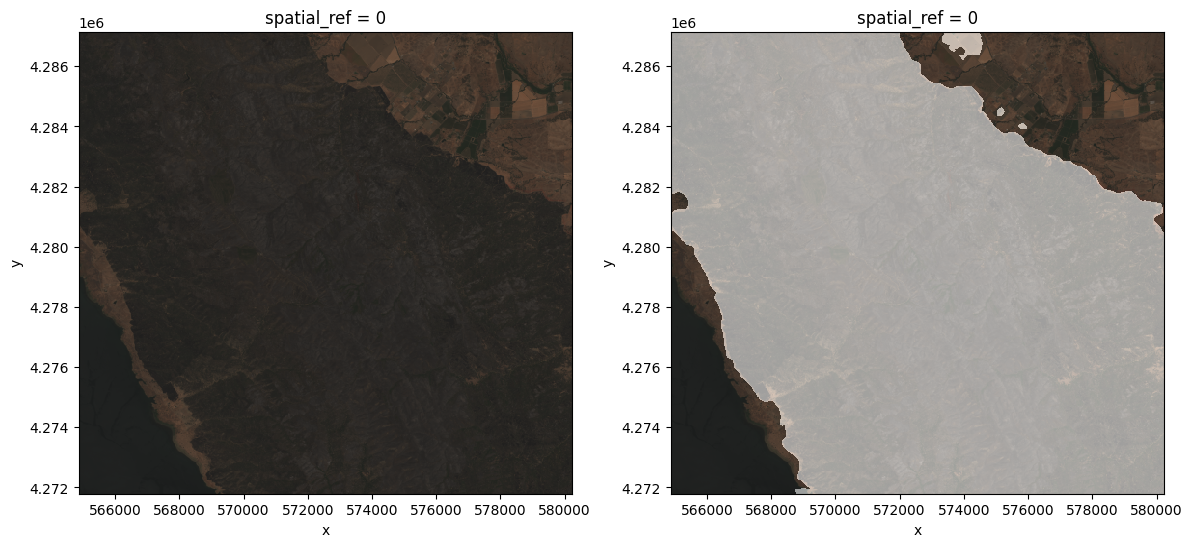

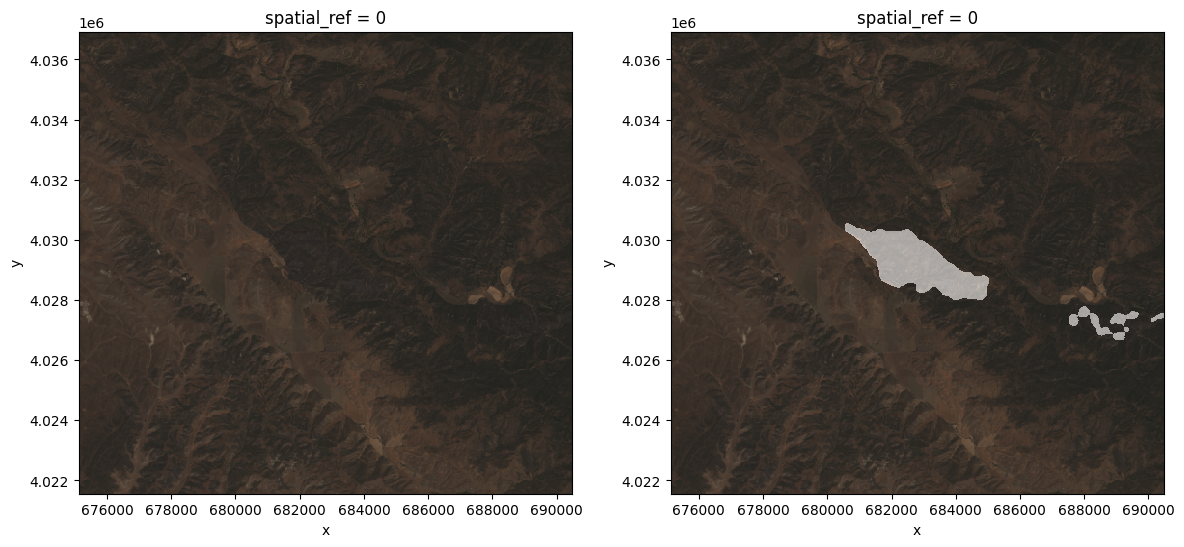

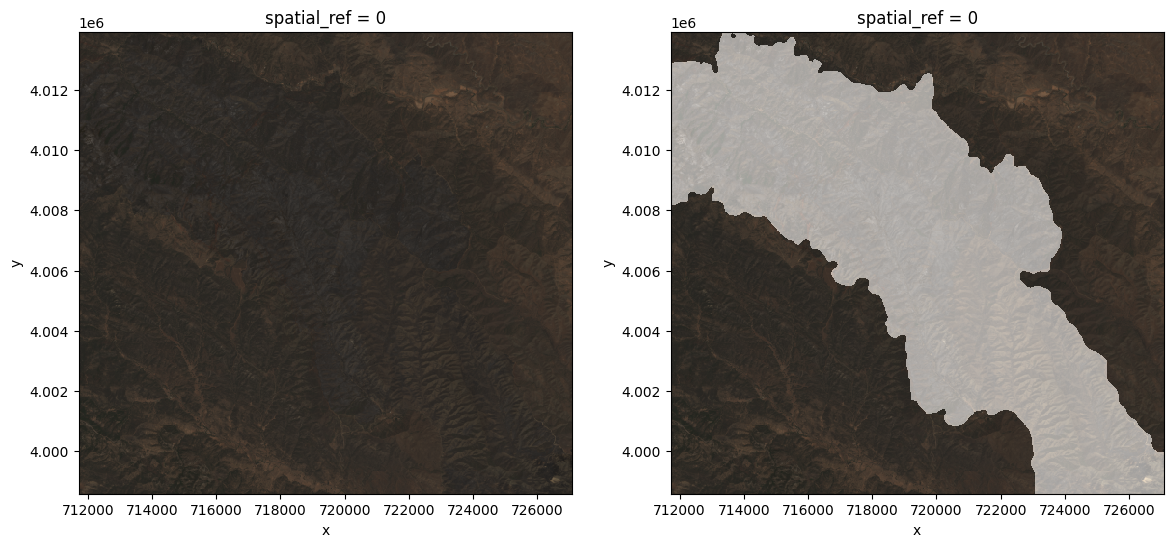

In [45]:
for pred, input_file in zip(predictions, file_names):
    fp = rioxarray.open_rasterio(input_file)              
    f, ax = plt.subplots(1,2, figsize=(14,6))
    (fp[[2,1,0]]+0.10).plot.imshow(rgb="band", ax=ax[0])
    (fp[[2,1,0]] + 0.10 + 0.5*np.stack(3*[pred], axis=0)).plot.imshow(rgb="band", ax=ax[1])

## **Tiled Inference**
### Now let's try an alternative form of inference - tiled inference. This type of inference is useful when the GPU (or the RAM associated with the CPU, if applicable) is insufficient to allocate all the information needed to run the model (basic libraries, model and data), because instead of applying the model to the whole image, it divides it into small rectangles, the dimensions of which are defined by the user, applies the model separately and then reconstructs the output figure. To perform this type of inference, we will use the file below. 

In [46]:
config_file_tiled = "burn_scars_config_tiled.yaml"

### Notice that the content is identical to the other YAML file, but the addition of the subfield: 
```
    tiled_inference_parameters:
      h_crop: 128
      h_stride: 64
      w_crop: 128
      w_stride: 64
      average_patches: true

```
### to the variables sent to the field `model`. The variables containing the suffix `_crop` refer to the dimensions of the tiles while those ones with the suffix `_stride` control the distance between them (the tiles can overlap).  

In [47]:
lightning_model = LightningInferenceModel.from_config(config_file_tiled, checkpoint, predict_dataset_bands, predict_output_bands)

/home/jalmeida/.pyenv/versions/3.12.7/envs/sbsr/lib/python3.12/site-packages/lightning/pytorch/cli.py:528: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['-f', '/home/jalmeida/.local/share/jupyter/runtime/kernel-14250d3d-3b57-4b7a-862f-71ebc3c97834.json'], args=['--config', 'burn_scars_config_tiled.yaml', '--data.init_args.predict_dataset_bands', '[BLUE,GREEN,RED,NIR_NARROW,-1,SWIR_2]', '--data.init_args.predict_output_bands', '[BLUE,GREEN,RED,NIR_NARROW,-1,SWIR_2]'].
Seed set to 2
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in p

In [48]:
predictions, file_names = lightning_model.inference_on_dir(input_dir)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


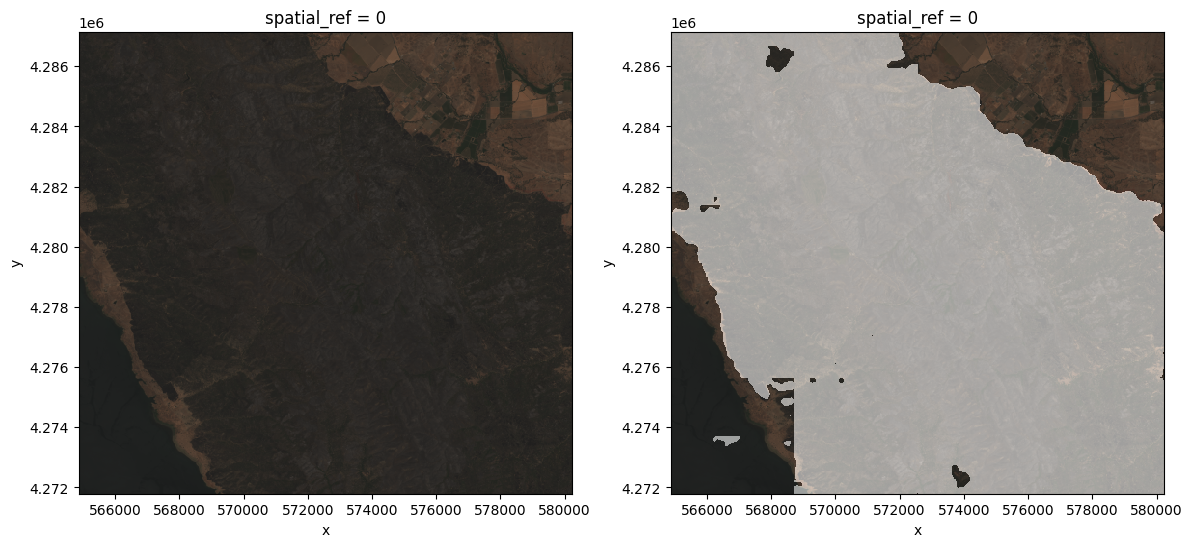

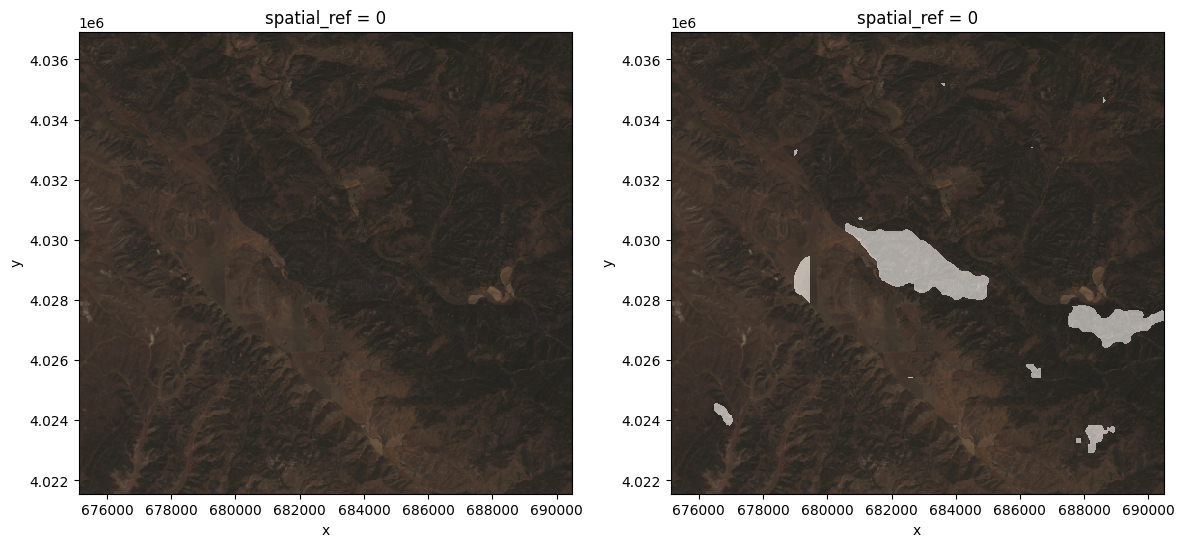

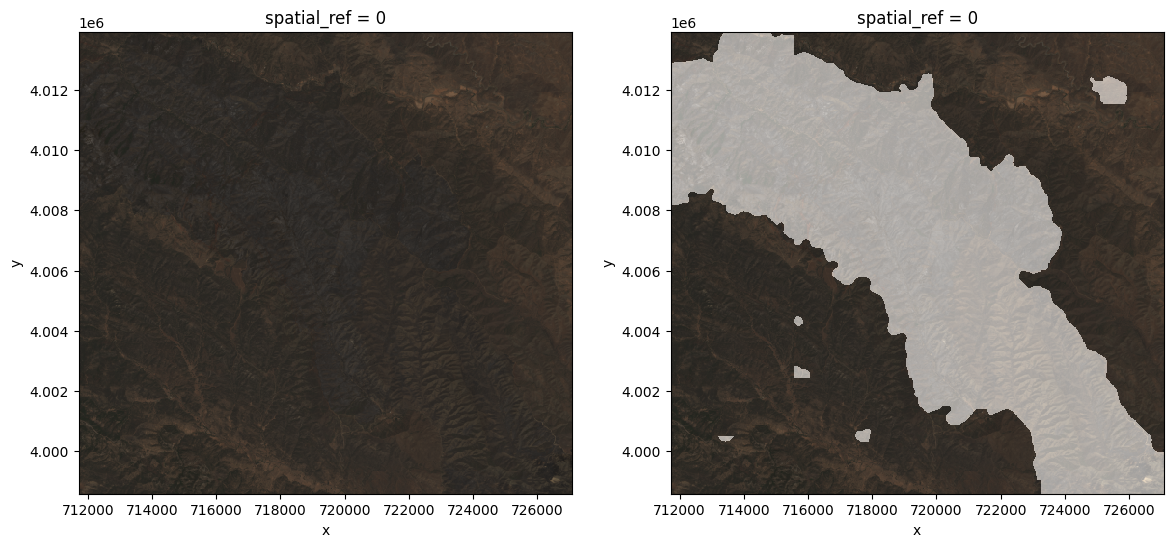

In [49]:
for pred, input_file in zip(predictions, file_names):
    fp = rioxarray.open_rasterio(input_file)
    f, ax = plt.subplots(1,2, figsize=(14,6))
    (fp[[2,1,0]]+0.10).plot.imshow(rgb="band", ax=ax[0])
    (fp[[2,1,0]] + 0.10 + 0.5*np.stack(3*[pred], axis=0)).plot.imshow(rgb="band", ax=ax[1])

### 1. You can try to modify the cell above in order to see the impact of the tiled inference parameters over the final output. 

### 2. You can try to replace the bands selected as input in order to check the inpact over the final output. You cna do it by replacing them with "-1".